In [1]:
import zipfile
from glob import glob
import os
from netCDF4 import Dataset
import pandas as pd
import geopandas as gpd # GeoPandas(지오판다스)
from shapely.geometry import Polygon, LineString, Point
path = os.getcwd()

import rasterio
from rasterio.plot import show
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

import numpy as np

import requests
import time

from geocube.api.core import make_geocube
import seaborn as sns

from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.__version__)
print(device_lib.list_local_devices())

In [2]:
path

'c:\\Users\\Go\\OneDrive - UOS\\allrepos\\UNet-project (2)'

## 모델 정의

In [3]:
INPUT_SHAPE = [64, 64, 45]

In [4]:
OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Unet():
  # data_augmentation = tf.keras.Sequential([
  #   # tf.keras.layers.RandomFlip('horizontal'), # "horizontal", "vertical", or "horizontal_and_vertical"
  #   # tf.keras.layers.RandomRotation(0.2),
  #   tf.keras.layers.GaussianNoise(   # 노이즈레이어 이부분도 학습에서만 활성화됨
  #       1, seed=None,
  #   )
  #   ])




  inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

  down_stack = [
    downsample(64, 3),  # (batch_size, 64, 64, 64)
    downsample(128, 3),  # (batch_size, 32, 32, 128)
    downsample(256, 3),  # (batch_size, 16, 16, 256)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
    downsample(512, 3),  # (batch_size, 4, 4, 512)
  ]

  up_stack = [
    upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 3),  # (batch_size, 8, 8, 1024)
    upsample(256, 3),  # (batch_size, 16, 16, 512)
    upsample(128, 3),  # (batch_size, 32, 32, 256)
    upsample(64, 3),  # (batch_size, 64, 64, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 2,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         )  # (batch_size, 256, 256, 3)  activation='tanh'

  x = inputs
  # x = data_augmentation(x)      

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## 데이터셋 생성

In [5]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _parse_function(tfrecord_serialized):
    features={
        'CMAQ_t': tf.io.FixedLenFeature([], tf.string),
        'SMOKE_t': tf.io.FixedLenFeature([], tf.string),
        'air_quality_monitoring_t': tf.io.FixedLenFeature([], tf.string),
        'weather_monitoring_t': tf.io.FixedLenFeature([], tf.string),
        'year': tf.io.FixedLenFeature([], tf.string),
        'month': tf.io.FixedLenFeature([], tf.string),
        'day': tf.io.FixedLenFeature([], tf.string),
        'hour': tf.io.FixedLenFeature([], tf.string),
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    cmaq = tf.io.decode_raw(parsed_features['CMAQ_t'], tf.float32)
    smoke = tf.io.decode_raw(parsed_features['SMOKE_t'], tf.float32)
    aq = tf.io.decode_raw(parsed_features['air_quality_monitoring_t'], tf.float64)  #이것 둘 64로 저장됨
    weather = tf.io.decode_raw(parsed_features['weather_monitoring_t'], tf.float64)
    year = tf.io.decode_raw(parsed_features['year'], tf.uint8)
    month = tf.io.decode_raw(parsed_features['month'], tf.uint8)
    day = tf.io.decode_raw(parsed_features['day'], tf.uint8)
    hour = tf.io.decode_raw(parsed_features['hour'], tf.uint8)

  

    cmaq = tf.reshape(cmaq, [82, 67, 1])
    print(cmaq.shape)
    smoke = tf.reshape(smoke, [82, 67, 45])
    print(smoke.shape)
    aq = tf.reshape(aq, [82, 67, 1])
    print(aq.shape)
    weather = tf.reshape(weather, [82, 67, 15])
    print(weather.shape)
    
    year = tf.squeeze(year)
    month = tf.squeeze(month)
    day = tf.squeeze(day)
    hour = tf.squeeze(hour)

    
    # image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    # image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])


    # classes = tf.io.decode_raw(parsed_features['classes'], tf.uint8)    
    # classes = tf.squeeze(classes)
    tf.cast(cmaq,tf.float32)

    return cmaq, smoke, aq, weather, year, month, day, hour

* 데이터셋 점검

In [6]:
BATCH_SIZE = 2
# exam_dataset = tf.data.TFRecordDataset(os.path.join("e:",'dataset_105.tfr'))
# exam_dataset = tf.data.TFRecordDataset([os.path.join(path,"dataset_record",'dataset_105.tfr'),os.path.join(path,"dataset_record",'dataset_106.tfr'),])
exam_dataset = tf.data.TFRecordDataset(os.path.join(path,"dataset_record",'dataset_105.tfr'))
exam_dataset = exam_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
exam_dataset = exam_dataset.prefetch(tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

(82, 67, 1)
(82, 67, 45)
(82, 67, 1)
(82, 67, 15)


In [7]:
for batch in exam_dataset.take(1):
    print(batch[6],batch[7])
    # break

tf.Tensor(
[[22  0  0  0]
 [22  0  0  0]], shape=(2, 4), dtype=uint8) tf.Tensor(
[[0 0 0 0]
 [1 0 0 0]], shape=(2, 4), dtype=uint8)


<AxesSubplot: >

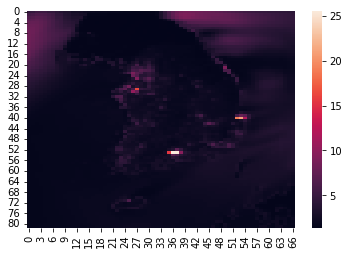

In [8]:
sns.heatmap(batch[0].numpy()[0,:,:,0][::-1])

<AxesSubplot: >

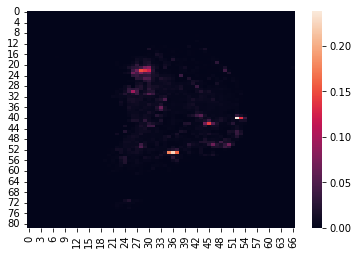

In [9]:
sns.heatmap(batch[1].numpy()[0,:,:,0][::-1])

<AxesSubplot: >

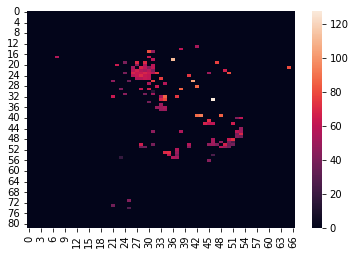

In [10]:
sns.heatmap(batch[2].numpy()[0,:,:,0])

<AxesSubplot: >

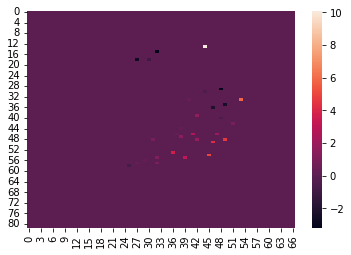

In [11]:
sns.heatmap(batch[3].numpy()[0,:,:,0])

In [12]:
batch[4]

<tf.Tensor: shape=(2, 4), dtype=uint8, numpy=
array([[13,  0,  0,  0],
       [13,  0,  0,  0]], dtype=uint8)>

In [13]:
batch[5]

<tf.Tensor: shape=(2, 4), dtype=uint8, numpy=
array([[3, 0, 0, 0],
       [3, 0, 0, 0]], dtype=uint8)>

In [14]:
batch[6]

<tf.Tensor: shape=(2, 4), dtype=uint8, numpy=
array([[22,  0,  0,  0],
       [22,  0,  0,  0]], dtype=uint8)>

In [15]:
batch[7]

<tf.Tensor: shape=(2, 4), dtype=uint8, numpy=
array([[0, 0, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)>

* 학습-검증셋 준비

In [23]:
def _parse_function2(tfrecord_serialized):
    features={
        'CMAQ_t': tf.io.FixedLenFeature([], tf.string),
        'SMOKE_t': tf.io.FixedLenFeature([], tf.string),
        # 'air_quality_monitoring_t': tf.io.FixedLenFeature([], tf.string),
        # 'weather_monitoring_t': tf.io.FixedLenFeature([], tf.string),
        # 'year': tf.io.FixedLenFeature([], tf.string),
        # 'month': tf.io.FixedLenFeature([], tf.string),
        # 'day': tf.io.FixedLenFeature([], tf.string),
        # 'hour': tf.io.FixedLenFeature([], tf.string),
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    cmaq = tf.io.decode_raw(parsed_features['CMAQ_t'], tf.float32)
    smoke = tf.io.decode_raw(parsed_features['SMOKE_t'], tf.float32)
    # aq = tf.io.decode_raw(parsed_features['air_quality_monitoring_t'], tf.float64)  #이것 둘 64로 저장됨
    # weather = tf.io.decode_raw(parsed_features['weather_monitoring_t'], tf.float64)
    # year = tf.io.decode_raw(parsed_features['year'], tf.uint8)
    # month = tf.io.decode_raw(parsed_features['month'], tf.uint8)
    # day = tf.io.decode_raw(parsed_features['day'], tf.uint8)
    # hour = tf.io.decode_raw(parsed_features['hour'], tf.uint8)

  

    cmaq = tf.reshape(cmaq, [82, 67, 1])
    # print(cmaq.shape)
    smoke = tf.reshape(smoke, [82, 67, 45])
    # print(smoke.shape)
    # aq = tf.reshape(aq, [82, 67, 1])
    # # print(aq.shape)
    # weather = tf.reshape(weather, [82, 67, 15])
    # print(weather.shape)
    
    # year = tf.squeeze(year)
    # month = tf.squeeze(month)
    # day = tf.squeeze(day)
    # hour = tf.squeeze(hour)

    
    # image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    # image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])


    # classes = tf.io.decode_raw(parsed_features['classes'], tf.uint8)    
    # classes = tf.squeeze(classes)
    # tf.cast(cmaq,tf.float32)
    # tf.concat([tf.cast(smoke,tf.float32),tf.cast(aq,tf.float32),tf.cast(weather,tf.float32),], axis=3)
    # tf.concat([tf.cast(smoke,tf.float32),tf.cast(aq,tf.float32),tf.cast(weather,tf.float32),], axis=2)[8:-10,2:-1,:]
    # return cmaq[8:-10,2:-1,:], tf.cast(smoke,tf.float32)[8:-10,2:-1,:], year, month, day, hour
    return smoke[8:-10,2:-1,:],cmaq[8:-10,2:-1,:]

In [24]:
all_tfr_path = glob(os.path.join(path,"dataset_record",'*.tfr'))
train_len = round(len(all_tfr_path) * 0.8)

train_tfr_path = list(np.random.choice(all_tfr_path,train_len, replace=False))

test_tfr_path = list(set(all_tfr_path) - set(train_tfr_path))
val_tfr_path = list(np.random.choice(test_tfr_path,1, replace=False))
test_tfr_path = list(set(test_tfr_path) - set(val_tfr_path))

print("trainset_n: ", train_len, "valset_n: ", len(val_tfr_path), "testset_n: ", len(test_tfr_path))

trainset_n:  6 valset_n:  1 testset_n:  1


In [53]:
BATCH_SIZE = 128
EPOCH = 30
N_RUN = 1000

In [26]:
# 학습셋, 셔플 x일단, 정규화도 x 나중에 12년도 데이터 사용해서 스케일링할것
train_dataset = tf.data.TFRecordDataset(train_tfr_path)
train_dataset = train_dataset.map(_parse_function2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

In [27]:
# 검증셋, 셔플 x일단, 정규화도 x 나중에 12년도 데이터 사용해서 스케일링할것
val_dataset = tf.data.TFRecordDataset(val_tfr_path)
val_dataset = val_dataset.map(_parse_function2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

In [28]:
# 검증셋, 셔플 x일단, 정규화도 x 나중에 12년도 데이터 사용해서 스케일링할것
test_dataset = tf.data.TFRecordDataset(test_tfr_path)
test_dataset = test_dataset.map(_parse_function2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

## 모델 학습

In [54]:
net_surrogate = Unet()

In [ ]:
# @tf.function()
# def train_step(input, label, network, loss_fun):
  
#   with tf.GradientTape() as tape:
#     ##로스 계산
#     pred = network(input)
    
#     loss = loss_fun(label, pred)
#   grads = tape.gradient(loss, network.trainable_variables)
#   optimizer.apply_gradients(zip(grads, network.trainable_variables))
#   return loss



# loss = tf.keras.losses.MeanSquaredError()
# optimizer = tf.keras.optimizers.Adam(0.0001)

# for epoc in range(EPOCH):
#     count = 0

#     for batch in train_dataset.take(N_RUN):

#       count += 1
#       mse_loss = train_step(batch[0],batch[1], net_surrogate,loss).numpy()
#       print(f"batch: {count}/{N_RUN} ---epoch: {epoc}/{EPOCH}--- mse-loss: {mse_loss}")

In [55]:
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.0001)

net_surrogate.compile(
    optimizer = optimizer,
    loss = loss,
    # metrics = ['mse', 'rmse']
)
net_surrogate.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 45)  0           []                               
                                ]                                                                 
                                                                                                  
 sequential_20 (Sequential)     (None, 32, 32, 64)   26176       ['input_3[0][0]']                
                                                                                                  
 sequential_21 (Sequential)     (None, 16, 16, 128)  74240       ['sequential_20[0][0]']          
                                                                                                  
 sequential_22 (Sequential)     (None, 8, 8, 256)    295936      ['sequential_21[0][0]']    

In [ ]:
history = net_surrogate.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=EPOCH
)

## 평가

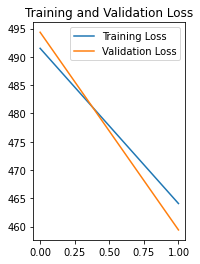

In [34]:
# 일단 val_set만 활용, 
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCH)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [58]:
predictions = net_surrogate.predict(test_dataset)

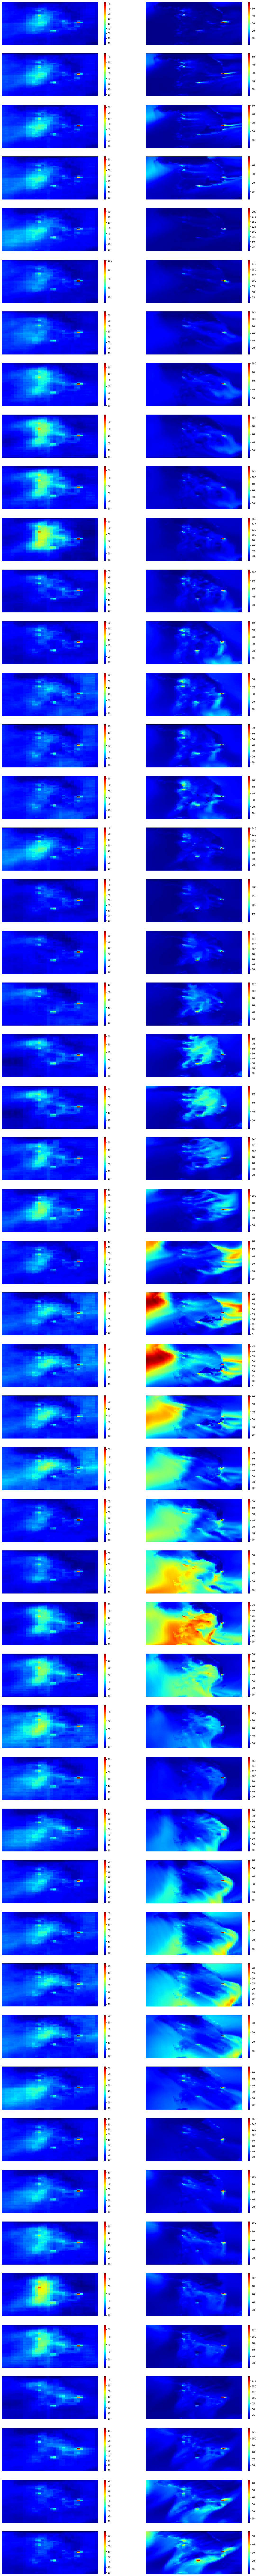

In [59]:
for batch in test_dataset.take(1):
    true = batch[1].numpy().reshape(-1,64,64)
    fig = plt.figure(figsize=(20,200))
    len = range(predictions.shape[0])[:100]
    for i in len:
        if i%2 == 0:
            plt.subplot(50, 2, i+1)
            sns.heatmap(predictions[i].reshape(64,64)[::-1], cmap = 'jet')
            plt.axis('off')
        else:
            plt.subplot(50, 2, i+1)
            sns.heatmap(true[i][::-1], cmap = 'jet')
            plt.axis('off')


        
    